To reproduce the data for this figure you have to use the following scripts:

1. Train the RBM for the TFIM: Script/energy_minimization.py --L=12 --model_params='{"J": 1, "h": 0.5}'
2. Obtain the distribution of $\epsilon$ for the TFIM by loading the trained RBM: Script/LPSE/eps_fe.py
3. Obtain the distribution of $\epsilon$ for the random initialized state: Script/LPSE/eps_fe.py --model='random'

Then you can use the following notebook to plot the data.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from functions import get_params_string
from Paper.figure_scripts import common

In [2]:
L = 12
n_dim = 1
PBC = True
arch = "RBM_alpha1"
dtype_ref = jnp.float64
dtypes = [jnp.float32, jnp.float16, jnp.bfloat16]
dtype_labels = ["f32", "f16", "bf16"]
model_labels = ["random", "TFIM", "Heisenberg"]
model_params = [None, {"J": 1, "h": 0.5}, {"J": 1}]

seed = 123

folder = f"{PROJECT_ROOT}/Data/LPSE/"


In [3]:
eps = []

for m, model_label in enumerate(model_labels):
    params_str = get_params_string(model_params[m])
    df_eps = pd.read_csv(f"{folder}Eps/FE/{model_label}{params_str}_{arch}_L{L}_{n_dim}dim.csv")

    e = []

    for dtype_label in dtype_labels:
        e.append(df_eps[dtype_label].to_numpy())
    eps.append(np.array(e).reshape((len(dtype_labels), -1)))

In [4]:
from scipy.stats import shapiro

stats = np.zeros((len(model_labels), len(dtype_labels)))
ps = np.zeros((len(model_labels), len(dtype_labels)))

for m in range(len(model_labels)):
    for d in range(len(dtype_labels)):
        stats[m, d], ps[m, d] = shapiro(eps[m][d])

stats, ps

(array([[0.97616904, 0.99907624, 0.99933147],
        [0.97346336, 0.99547648, 0.99542535],
        [0.99309729, 0.99859075, 0.99198052]]),
 array([[1.21151953e-25, 2.69551667e-02, 1.39089541e-01],
        [6.14021828e-27, 6.41269405e-10, 5.34100550e-10],
        [2.76900949e-04, 6.80334077e-01, 6.57998190e-05]]))

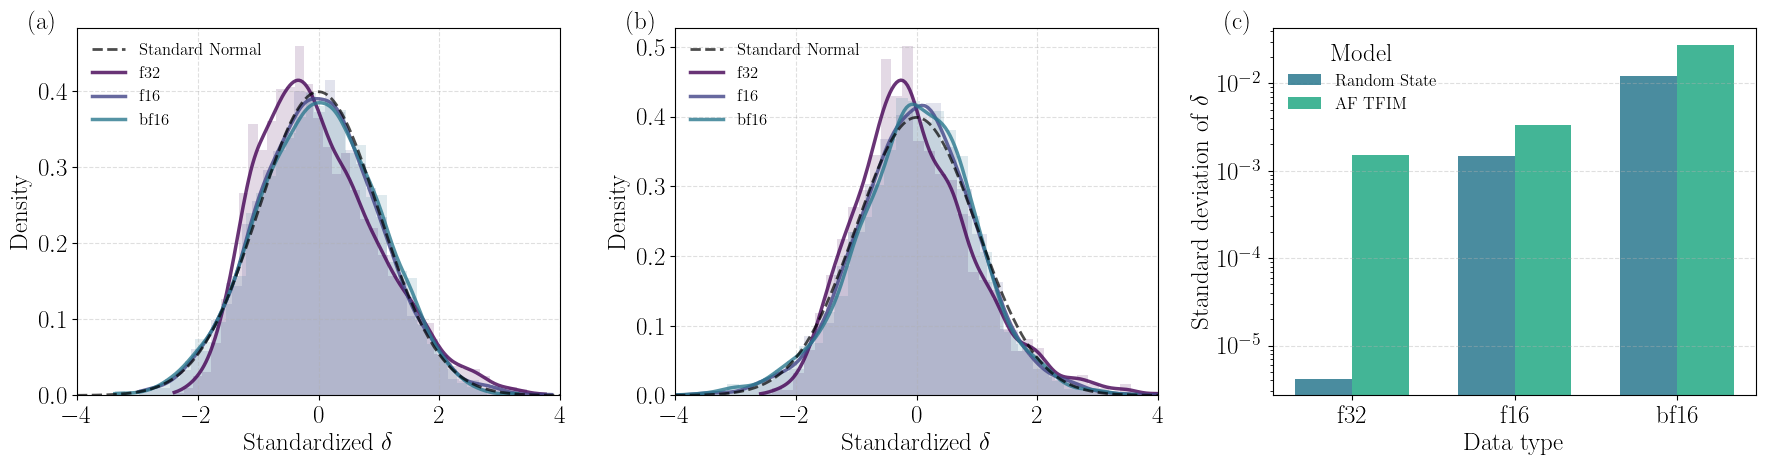

In [5]:
from scipy import stats as sp_stats

colors = plt.cm.viridis(np.linspace(0, 0.8, len(dtype_labels) + 2))
model_labels = ["Random State", "AF TFIM"]  

eps_subset = eps[:2]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for j in range(len(model_labels)):
    ax = axes[j]
    ax.text(-0.1, 1.05, f'({chr(97+j)})', transform=ax.transAxes, fontweight='bold', va='top')
    
    x_ref = np.linspace(-4, 4, 200)
    ax.plot(x_ref, sp_stats.norm.pdf(x_ref), 'k--', linewidth=2, 
            label='Standard Normal', alpha=0.7, zorder=10)
    
    for i, e in enumerate(eps_subset[j]):
        e_standardized = (e - np.mean(e)) / np.std(e)
        
        density = sp_stats.gaussian_kde(e_standardized)
        x_plot = np.linspace(e_standardized.min(), e_standardized.max(), 200)
        ax.plot(x_plot, density(x_plot), color=colors[i], linewidth=2.5, 
                label=dtype_labels[i], alpha=0.8)
        
        ax.hist(e_standardized, bins=40, alpha=0.15, color=colors[i], 
                edgecolor='none', density=True)
    
    ax.legend(loc='upper left', frameon=False)
    ax.set_xlabel(r"Standardized $\delta$")
    ax.set_ylabel("Density")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_xlim(-4, 4)

ax_var = axes[2]
ax_var.text(-0.1, 1.05, '(c)', transform=ax_var.transAxes,
            fontweight='bold', va='top')

# x-axis: dtypes
x = np.arange(len(dtype_labels))
bar_width = 0.35

# compute stds: shape (n_models, n_dtypes)
stds = np.array([
    [np.std(eps_subset[m][j, :]) for j in range(len(dtype_labels))]
    for m in range(len(model_labels))
])

# plot bars
for m, model in enumerate(model_labels):
    ax_var.bar(
        x + (m - 0.5) * bar_width,
        stds[m],
        width=bar_width,
        label=model,
        alpha=0.85,
        color=colors[m + len(dtype_labels) - 1]
    )

# formatting
ax_var.set_xticks(x)
ax_var.set_xticklabels(dtype_labels)
ax_var.set_yscale("log")
ax_var.set_ylabel(r"Standard deviation of $\delta$")
ax_var.legend(frameon=False, title="Model")
ax_var.grid(True, linestyle='--', alpha=0.4, axis='y')
ax_var.set_xlabel('Data type')

plt.tight_layout()
plt.show()